<a href="https://colab.research.google.com/github/sunnyday2/flight_on_time/blob/desarrollo/entrenamiento_MVPv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción al Notebook: Predicción de Retrasos de Vuelos

Este notebook tiene como objetivo principal desarrollar y evaluar modelos de Machine Learning capaces de predecir si un vuelo sufrirá un retraso. Se abordan las fases clave de un proyecto de ciencia de datos:

1.  **Carga y Exploración de Datos:** Se carga un dataset que combina información de vuelos con datos meteorológicos.
2.  **Preprocesamiento de Datos:** Se limpian los datos, se manejan valores nulos y se transforman las variables para hacerlas aptas para los modelos.
3.  **Entrenamiento y Evaluación de Modelos:** Se construyen y entrenan dos tipos de modelos: Regresión Logística (un modelo base simple) y Random Forest (un modelo de conjunto más avanzado). Ambos se evalúan utilizando métricas como el Classification Report, ROC AUC y Matrices de Confusión.
4.  **Simulación de Predicciones:** Se crea una función que simula un "endpoint" de API para realizar predicciones con nuevos datos, mostrando cómo se usaría el modelo en un entorno real.
5.  **Análisis de Resultados y Conclusiones:** Se analizan los resultados de los modelos, se visualizan su rendimiento y se extraen conclusiones sobre cuál es el mejor modelo para el caso de uso, junto con posibles mejoras futuras.

### Paso 1: Importación de Librerías

Esta celda importa todas las librerías necesarias para el desarrollo del proyecto. Incluye:

*   **`pandas` y `numpy`**: Para manipulación y análisis de datos.
*   **`sklearn`**: Para tareas de Machine Learning como la división de datos (`train_test_split`), preprocesamiento (`ColumnTransformer`, `OneHotEncoder`), creación de pipelines (`Pipeline`), modelos (`LogisticRegression`, `RandomForestClassifier`) y métricas de evaluación (`classification_report`, `roc_auc_score`, `confusion_matrix`, `roc_curve`).
*   **`joblib`**: Para guardar y cargar modelos entrenados en formato `pkl`.
*   **`matplotlib.pyplot`**: Para la visualización de datos y resultados.

In [ ]:
# -*- coding: utf-8 -*-
"""Entrenamiento_MVP.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1_FyPKCFfdZ9HRGUqytYJXlyQcCvvpraN
"""

import pandas as pd
import numpy as np


#train_test_split: separa datos en entrenamiento y test
#ColumnTransformer: aplica transformaciones distintas a columnas distintas
#OneHotEncoder: convierte categorías (aerolíneas) en números
#Pipeline: encadena pasos (preprocesado + modelo)
#LogisticRegression: modelo base del MVP
#Métricas para evaluar el modelo

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

import joblib
#joblib permite guardar y cargar modelos entrenados .pkl


### Paso 2: Carga y Exploración Inicial del Dataset

En esta celda, cargamos el dataset principal que contiene la información de vuelos combinada con datos climáticos. El dataset se obtiene directamente desde una URL en GitHub. Después de cargar los datos en un DataFrame de pandas, se muestran las dimensiones del DataFrame (`df.shape`) y las primeras filas (`df.head()`) para una inspección rápida y verificar la estructura de los datos.

In [ ]:
# Cargamos el dataset final ya preparado
# Contiene información del vuelo + clima + variable objetivo (delayed)

#df = pd.read_csv("dataset_vuelos_clima_final.csv")
df = pd.read_csv("https://raw.githubusercontent.com/sunnyday2/flight_on_time/refs/heads/desarrollo/dataset_vuelos_clima_final.csv")

# Mostramos tamaño del dataset y primeras filas para inspección rápida

print(df.shape)
df.head()


(1654, 14)


,flightdate,origincityname,crsdeptime,depdelay,distance,marketing_airline_network,hour,delayed,city_clean,latitude,longitude,temp_mean,precipitation,wind_speed
0,2018-01-11,"Minneapolis, MN",650,-1.0,1034.0,DL,6,0,Minneapolis,44.97997,-93.26384,-6.0,4.3,16.2
1,2018-01-23,"Honolulu, HI",2200,-2.0,2994.0,DL,22,0,Honolulu,21.30694,-157.85834,23.2,0.1,22.6
2,2018-01-12,"Charlotte, NC",1810,-3.0,394.0,AA,18,0,Charlotte,35.22709,-80.84313,16.6,13.0,19.8
3,2018-01-22,"Hartford, CT",535,-5.0,549.0,DL,5,0,Hartford,41.76371,-72.68509,2.2,0.9,4.3
4,2018-01-02,"Corpus Christi, TX",1615,139.0,354.0,AA,16,1,Corpus Christi,27.80058,-97.39638,1.9,2.3,17.0


### Paso 3: Preprocesamiento de Datos y Configuración del Pipeline

Esta celda es fundamental para preparar los datos antes del entrenamiento del modelo:

1.  **Limpieza de Nulos y Filtrado**: Se definen columnas obligatorias (`required_cols`) y se eliminan las filas con valores nulos en estas columnas. También se filtran las filas para asegurar que las horas de vuelo estén en un rango válido (0-23) y las distancias sean mayores que cero.
2.  **Definición de Features y Target**: Se especifican las columnas que se usarán como características (`FEATURES`) para la predicción y la columna objetivo (`TARGET`, que indica si hay retraso).
3.  **Separación de Datos (X e y)**: Se divide el DataFrame en `X` (características de entrada) e `y` (la variable a predecir).
4.  **Definición de Columnas Numéricas y Categóricas**: Se identifican qué columnas son numéricas y cuáles categóricas, lo cual es crucial para el siguiente paso.
5.  **Configuración del `ColumnTransformer`**: Se crea un `ColumnTransformer` que aplicará diferentes transformaciones a diferentes tipos de columnas: las columnas numéricas se pasan "tal cual" (`passthrough`), mientras que las columnas categóricas se transforman usando `OneHotEncoder`. Esto convierte las categorías de texto (como los nombres de aerolíneas) en un formato numérico binario que los modelos pueden entender. `handle_unknown='ignore'` previene errores si aparecen nuevas categorías no vistas durante el entrenamiento.
6.  **Creación del Pipeline del Modelo**: Se construye un `Pipeline` que encadena dos pasos: el preprocesamiento definido anteriormente y un modelo de `LogisticRegression`. Se configura `max_iter=1000` para asegurar la convergencia y `class_weight='balanced'` para manejar el desbalance de clases (ya que los retrasos son menos frecuentes que los vuelos puntuales).

In [ ]:
#columnas que queremos obligatorias o minimas

required_cols = [
    "hour",
    "distance",
    "marketing_airline_network",
    "temp_mean",
    "precipitation",
    "wind_speed",
    "delayed"
]

#limpio nulos en columnas clave

df = df.dropna(subset=required_cols)

#elimino horas y vuelos que no valen. Fuera de rango de hora realista y distancias no válidas

df = df[df["hour"].between(0, 23)]
df = df[df["distance"] > 0]

#elegimos columnas para input.

FEATURES = [
    "hour",
    "distance",
    "marketing_airline_network",
    "temp_mean",
    "precipitation",
    "wind_speed"
]

TARGET = "delayed"

#separamos x= lo que sabemos antes del vuelo de y = lo que queremos predecir

X = df[FEATURES]
y = df[TARGET]

#lista columnas numericas, distinto a categorías. Columnas van a ser números y columnas van a ser texto o categoría para ColumnTransformer (siguiente celda)

numeric_features = [
    "hour",
    "distance",
    "temp_mean",
    "precipitation",
    "wind_speed"
]

categorical_features = [
    "marketing_airline_network"
]

#Aquí es la "adaptación" a las normas JSON. El JSON se convierte en dataframe. El pipeline aplica esas transformaciones en entrenamiento.
#Las variables numéricas no se escalan (se podría hacer). Las variables que son categorías se convierten con one hot.
#handle_unknown="ignore" evita errores con aerolíneas nuevas


#procesamos. pasamos numéricas como están y aplicamos One Hot Encoding para evitar leakage

preprocessor = ColumnTransformer(        #a las columnas las sometemos a transfomación: las numericas y las categóricas
    transformers=[
        ("num", "passthrough", numeric_features),    #las variables numericas estan bien, que no las toque (passthrough)
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)   #convertimos texto en columnas numéricas (onehot)
    ]
)


#Ahora todo dataframe pasa por estas reglas

#logistic regression, class_weight="balanced": corrige desbalance, max_iter=1000: asegura convergencia
#funciona sin escalado porque no tenemos magnitudes extremas. Añadir StandarScaler
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

#80% entrenamiento, 20% test manteniendo proporción retrasos. #x son columnas preictibles y es la respuesta. Miramos x para preecir y


### Paso 4: Entrenamiento y Evaluación del Modelo de Regresión Logística

Esta celda ejecuta el entrenamiento y la primera evaluación del modelo de Regresión Logística:

1.  **División de Datos (Entrenamiento y Test)**: Se utiliza `train_test_split` para dividir los datos `X` e `y` en conjuntos de entrenamiento (80%) y prueba (20%). El parámetro `stratify=y` es crucial para asegurar que la proporción de vuelos retrasados y puntuales se mantenga similar en ambos conjuntos, lo cual es importante en datasets desbalanceados.
2.  **Entrenamiento del Modelo**: El `pipeline` (`model`) es entrenado con los datos de entrenamiento (`X_train`, `y_train`). Durante este paso, el preprocesador transforma los datos y luego la Regresión Logística aprende los patrones para predecir retrasos.
3.  **Predicciones**: Se realizan dos tipos de predicciones sobre el conjunto de prueba (`X_test`):
    *   `y_pred`: Predicciones binarias (0 = Puntual, 1 = Retrasado).
    *   `y_proba`: Probabilidades de que un vuelo se retrase (la probabilidad de la clase 1).
4.  **Evaluación**: Se imprimen dos métricas clave para evaluar el rendimiento del modelo:
    *   `classification_report`: Ofrece un resumen detallado de la precisión (precision), la exhaustividad (recall) y la puntuación F1 para ambas clases.
    *   `roc_auc_score`: Mide la capacidad del modelo para distinguir entre vuelos puntuales y retrasados.
5.  **Guardado del Modelo**: El modelo entrenado se guarda en un archivo `flight_delay_model.pkl` usando `joblib`. Esto permite que el modelo pueda ser cargado y utilizado posteriormente sin necesidad de reentrenarlo.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(     #rompemos en 2 el set
    X,
    y,
    test_size=0.2,     #20% e atos para examen
    random_state=42,
    stratify=y           #nos aseguramos se mantenga la proporción sies y noes
)

#hacemos que aprenda patrones de delay

model.fit(X_train, y_train)

#predicciçon binaria y probabilidad de retraso. #medimos precisión, recall, f1 y capacidad de ranking ROC AUC

from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)                   #el modelo responde con decisiones 1 retraso 0 no retraso
y_proba = model.predict_proba(X_test)[:, 1]        #que tan probable es el retraso, me da solo la clase 1: retraso

print("Classification Report:\n")
print(classification_report(y_test, y_pred))         #informe clasificación que nos mide: cuantos vuelos se retrasaron realmente, el recall (cuantos etectamos ) y F1 (lo que  falla)

print("ROC AUC:", roc_auc_score(y_test, y_proba))      #ordenamos casos de mayor a menor riesgo. 1 es perfecto, 5 azar

#guardamos modelo en pickle, listo para backend.


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.70      0.78       269
           1       0.31      0.58      0.40        62

    accuracy                           0.68       331
   macro avg       0.59      0.64      0.59       331
weighted avg       0.77      0.68      0.71       331

ROC AUC: 0.6894112003837392


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Paso 5: Entrenamiento y Evaluación del Modelo Random Forest

Esta celda introduce un segundo modelo, un `RandomForestClassifier`, que es un modelo de conjunto basado en árboles de decisión, generalmente más potente que la Regresión Logística:

1.  **Configuración del Pipeline para Random Forest**: Se crea un nuevo `pipeline` (`rf_model`) que utiliza el mismo `preprocessor` que antes, pero en este caso, el clasificador es un `RandomForestClassifier`. Se configuran algunos hiperparámetros como `n_estimators` (número de árboles, 100 es un valor común), `max_depth` (profundidad máxima de cada árbol), `random_state` para reproducibilidad, y `class_weight='balanced'` para manejar el desbalance de clases.
2.  **Entrenamiento del Modelo Random Forest**: El `rf_model` se entrena con los mismos datos de entrenamiento (`X_train`, `y_train`).
3.  **Predicciones**: Se obtienen las predicciones binarias (`y_pred_rf`) y las probabilidades de retraso (`y_proba_rf`) para el conjunto de prueba.
4.  **Evaluación**: Se imprimen las métricas de evaluación (`classification_report` y `roc_auc_score`) específicas para el modelo Random Forest. Esto permite comparar su rendimiento con el de la Regresión Logística.

In [ ]:
import joblib

joblib.dump(model, "flight_delay_model.pkl")

#hacemos random forest: conjunto de árboles que votan una decisión final.

from sklearn.ensemble import RandomForestClassifier

#random forest

rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),                  #convertimos texto en numeros, ascalamos valores, rellenamos datos faltantes, ya que el modelo no entiende texto ni celdas vacías.
    ("classifier", RandomForestClassifier(
        n_estimators=100,                           #numero de arboles en el bosque (100 es lo standar)
        max_depth=10,                               #que tan alto crece cada arbol (muy alto se equivoca ya que memoriza, bajo generaliza mejor, 10 es lo standar)
        random_state=42,                            #todos los arboles crecen igual
        class_weight="balanced"                     #si hay pocos retrasos que no se ignoren porque hay muchos NO
    ))
])

rf_model.fit(X_train, y_train)         #se limpian datos, se crean 100 arboles, cada arbol aprende una cosa distinta, el bosque entero aprende y emite su voto por cada arbol y gana la mayoría.

y_pred_rf = rf_model.predict(X_test)                   #mira cada vuelo y responbde 0 (no delay) o 1 (si delay)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]       #qué probabilidad hay de retraso, dame solo 1 (probabilidad de delay)

print("RANDOM FOREST - Classification Report:\n")       #informe de clasificación: precision recall y f1
print(classification_report(y_test, y_pred_rf))

print("RANDOM FOREST - ROC AUC:", roc_auc_score(y_test, y_proba_rf))      #vemos que ordene bien

#simulamos endpoint como API
#el modelo no recibe el JSON directamente, lo adaptamos como dataframe, que es lo que haría backend creo


RANDOM FOREST - Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       269
           1       0.48      0.34      0.40        62

    accuracy                           0.81       331
   macro avg       0.67      0.63      0.64       331
weighted avg       0.79      0.81      0.79       331

RANDOM FOREST - ROC AUC: 0.7273354119198944


### Paso 6: Simulación de Endpoint, Guardado Final del Modelo y Visualizaciones Adicionales

Esta celda tiene múltiples propósitos:

1.  **Función `predict_flight_delay`**: Define una función que simula cómo un "endpoint" de una API recibiría una solicitud (en formato JSON), preprocesaría los datos de entrada y usaría el modelo entrenado para generar una predicción y una probabilidad de retraso. Se usan valores por defecto para la temperatura, precipitación y velocidad del viento, simulando el enfoque MVP (Producto Mínimo Viable).
2.  **Ejemplo de Uso**: Se muestra un `input_example` con datos de un vuelo simulado y se llama a la función `predict_flight_delay` para obtener una predicción, imprimiendo la respuesta.
3.  **Guardado del Modelo Ajustado**: El modelo (`model`, que es la Regresión Logística) se guarda con el nombre "MVP_entrenamiento.pkl". Esto podría generar confusión si se esperaba guardar el Random Forest.
4.  **Visualizaciones del Modelo (Regresión Logística)**: El resto de la celda se dedica a crear varias visualizaciones para entender mejor el rendimiento del modelo de Regresión Logística:
    *   **`Distribución de clases`**: Un gráfico de barras que muestra el número de vuelos puntuales y retrasados en el dataset.
    *   **`Histograma de probabilidades`**: Muestra la distribución de las probabilidades de retraso predichas por el modelo en el conjunto de prueba, indicando si el modelo es capaz de separar bien las clases.
    *   **`Curva ROC`**: Un gráfico que evalúa la capacidad discriminativa del modelo para diferenciar entre clases, complementando el ROC AUC.
    *   **`Importancia de las variables`**: Un gráfico de barras que muestra el peso (coeficientes) de cada característica en el modelo de Regresión Logística, indicando cuáles tienen mayor impacto en la predicción.

{'prevision': 'Puntual', 'probabilidad': 0.24}


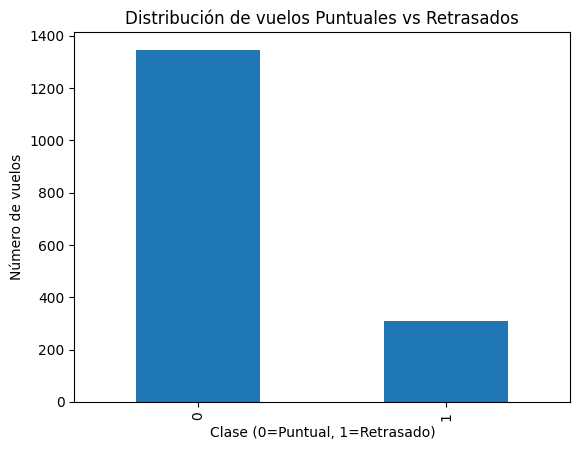

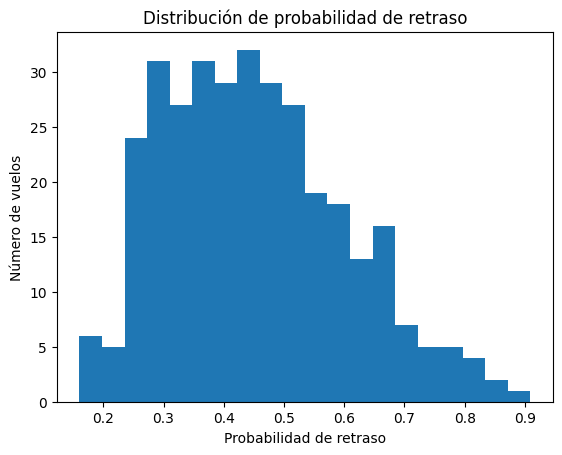

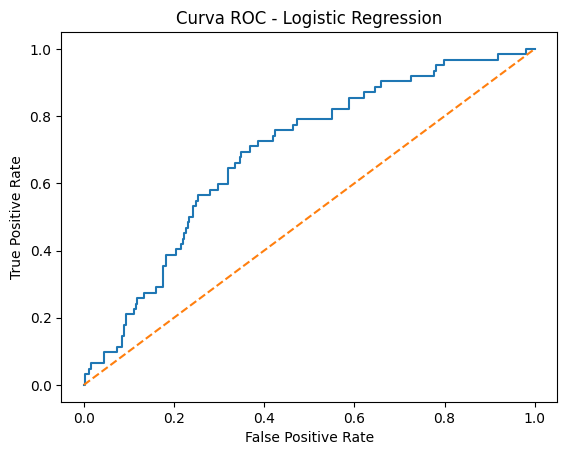

In [ ]:
import pandas as pd

def predict_flight_delay(input_json, model):    #creamos una función que predice si un vuelo se retrasa input_json simula el JSON. Mi función recibe un diccionario de python, no directamente el json
    """
    Simula el endpoint POST /predict
    """

    #Parsear fecha

    fecha = pd.to_datetime(input_json["fecha_partida"])


    #Construir DataFrame de entrada

    df_input = pd.DataFrame([{
        "hour": fecha.hour,
        "distance": input_json["distancia_km"],
        "marketing_airline_network": input_json["aerolinea"],
        "temp_mean": 20.0,        # valor por defecto (MVP)
        "precipitation": 0.0,     # valor por defecto (MVP)
        "wind_speed": 10.0        # valor por defecto (MVP)
    }])

    #Predicción
    pred = model.predict(df_input)[0]
    proba = model.predict_proba(df_input)[0, 1]

    #Respuesta
    return {
        "prevision": "Retrasado" if pred == 1 else "Puntual",
        "probabilidad": round(float(proba), 2)
    }

#ejemplo de request

input_example = {                   #simula el json que llegaría desde una API. El back end transforma el json en python y llama a la funcion.
    "aerolinea": "AZ",
    "origen": "GIG",
    "destino": "GRU",
    "fecha_partida": "2025-11-10T14:30:00",
    "distancia_km": 350
}

response = predict_flight_delay(input_example, model)
print(response)

import joblib

joblib.dump(model, "MVP_entrenamiento.pkl")

#Distribución clases, historiograma de probabilidades, curva ROC, vareiables importantes


import matplotlib.pyplot as plt

df["delayed"].value_counts().plot(kind="bar")   #contamos cuantos puntuales 0 o retrasados 1
plt.title("Distribución de vuelos Puntuales vs Retrasados")
plt.xlabel("Clase (0=Puntual, 1=Retrasado)")
plt.ylabel("Número de vuelos")
plt.show()

# Este histograma muestra cómo se distribuyen las probabilidades
# que el modelo asigna a los vuelos de test
# Nos permite ver si el modelo separa bien casos de bajo y alto riesgo


plt.hist(y_proba, bins=20)
plt.title("Distribución de probabilidad de retraso")
plt.xlabel("Probabilidad de retraso")
plt.ylabel("Número de vuelos")
plt.show()

# Importamos la función para calcular la curva ROC
# La curva ROC evalúa la capacidad del modelo para
# diferenciar entre vuelos puntuales y retrasados

from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_proba)     # Calculamos la tasa de falsos positivos (FPR) y la tasa de verdaderos positivos (TPR)

plt.plot(fpr, tpr)                             # Dibujamos la curva ROC del modelo
plt.plot([0, 1], [0, 1], linestyle="--")         # Línea diagonal = modelo aleatorio (sin capacidad predictiva)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Logistic Regression")
plt.show()

# Obtener nombres reales de las features. Numéricas se mantienen igual.
numeric_names = numeric_features

# Las categóricas se expanden en múltiples columnas por el One Hot Encoding

categorical_names = (
    model.named_steps["preprocess"]
    .named_transformers_["cat"]
    .get_feature_names_out(categorical_features)
)

# Unimos todas las variables en una sola lista

feature_names = list(numeric_names) + list(categorical_names)

# Coeficientes del modelo de regresión log.
coefficients = model.named_steps["classifier"].coef_[0]    #Extrae el peso real de cada feature

#Creamos dataframe para manejar mejor

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": coefficients
}).sort_values(by="importance")




### Paso 7: Predicciones Múltiples y Visualización del Impacto de las Variables

Esta celda continúa con las visualizaciones y demuestra cómo se harían múltiples predicciones:

1.  **Gráfica de Importancia de Variables**: Retoma la visualización de la importancia de las características del modelo de Regresión Logística, mostrando su peso en la decisión final.
2.  **Redefinición de `predict_flight_delay`**: La función `predict_flight_delay` se vuelve a definir aquí. Aunque esto es redundante si la celda anterior ya fue ejecutada, asegura que la función esté disponible en este contexto.
3.  **Simulación de Múltiples Llamadas al Endpoint**: Se define una lista de `inputs` (cuatro vuelos simulados diferentes) para demostrar cómo la función de predicción respondería a múltiples solicitudes.
4.  **Recolección de Resultados**: Se itera sobre la lista de `inputs`, se llama a `predict_flight_delay` para cada uno y se almacenan los resultados (vuelo, aerolínea, probabilidad de retraso y previsión final) en una lista `results`.
5.  **Visualización de Resultados**: La lista `results` se convierte en un DataFrame (`df_results`) y se utiliza para crear un gráfico de barras. Este gráfico muestra la probabilidad de retraso para cada vuelo simulado, con etiquetas de texto indicando si la previsión final es "Puntual" o "Retrasado", lo que simula visualmente la respuesta de un sistema en producción.

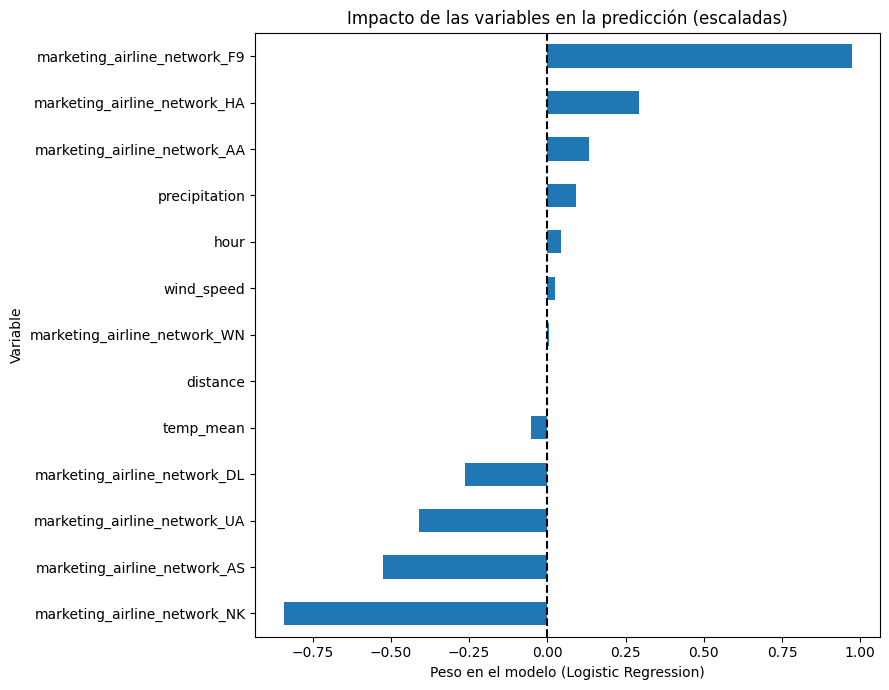

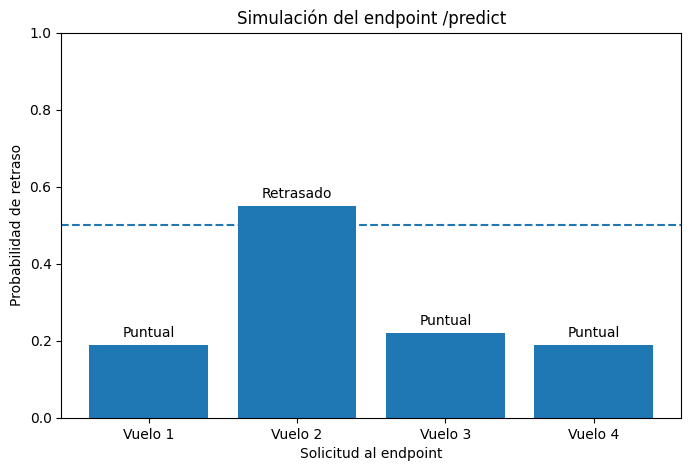

In [ ]:
# Gráfica
importance_df.plot(
    x="feature",
    y="importance",
    kind="barh",
    figsize=(9, 7),
    legend=False
)

plt.axvline(0, color="black", linestyle="--")
plt.title("Impacto de las variables en la predicción (escaladas)")
plt.xlabel("Peso en el modelo (Logistic Regression)")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

def predict_flight_delay(input_json, model):
    fecha = pd.to_datetime(input_json["fecha_partida"])

    df_input = pd.DataFrame([{                                #aquí es donde convbertimos los datos en datos útiles segun JSON
        "hour": fecha.hour,
        "distance": input_json["distancia_km"],
        "marketing_airline_network": input_json["aerolinea"],
        "temp_mean": 20.0,
        "precipitation": 0.0,
        "wind_speed": 10.0
    }])

    pred = model.predict(df_input)[0]                     #pred= decision final, si o no.
    proba = model.predict_proba(df_input)[0, 1]           #proba= probabilidad de retraso

    return {
        "prevision": "Retrasado" if pred == 1 else "Puntual",
        "probabilidad": round(float(proba), 2)
    }

#Llamamos al endpoint varias veces. Usamos claves según JSON.

inputs = [
    {
        "aerolinea": "AZ",
        "fecha_partida": "2025-11-10T08:30:00",
        "distancia_km": 300
    },
    {
        "aerolinea": "F9",
        "fecha_partida": "2025-11-10T19:45:00",
        "distancia_km": 1200
    },
    {
        "aerolinea": "AA",
        "fecha_partida": "2025-11-10T06:15:00",
        "distancia_km": 800
    },
    {
        "aerolinea": "NK",
        "fecha_partida": "2025-11-10T22:10:00",
        "distancia_km": 1500
    }
]

results = []             #lista vacía donde guardamos resultados

# Recorremos la lista de inputs simulando varias llamadas al endpoint. enumerate nos da un índice (i) y el contenido del input (inp)

for i, inp in enumerate(inputs):
    response = predict_flight_delay(inp, model)       # Llamamos a la función de predicción como si fuera una API
    results.append({                                       # Guardamos el resultado en la lista y añadimos información útil para visualizarla luego en una tabla
        "vuelo": f"Vuelo {i+1}",                           #identificador vuelo
        "aerolinea": inp["aerolinea"],                    #aerolinea
        "probabilidad": response["probabilidad"],            #probabilidad e retraso
        "prevision": response["prevision"]                    #final: puntual o retrasado
    })

# Convertimos la lista de resultados en un DataFrame y lo vemos

df_results = pd.DataFrame(results)
df_results

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Creamos un gráfico de barras
# Cada barra representa una llamada al endpoint (un vuelo)
# La altura de la barra es la probabilidad de retraso

plt.bar(
    df_results["vuelo"],
    df_results["probabilidad"]
)

plt.axhline(0.5, linestyle="--")
plt.title("Simulación del endpoint /predict")
plt.ylabel("Probabilidad de retraso")
plt.xlabel("Solicitud al endpoint")

for i, row in df_results.iterrows():
    plt.text(
        i,
        row["probabilidad"] + 0.02,
        row["prevision"],
        ha="center"
    )

plt.ylim(0, 1)
plt.show()

### Paso 8: Matriz de Confusión para Regresión Logística

Esta celda se enfoca en una métrica de evaluación clave: la **Matriz de Confusión**.

1.  **Importación de `confusion_matrix` y `ConfusionMatrixDisplay`**: Estas funciones de `sklearn.metrics` son esenciales para crear y visualizar la matriz.
2.  **Cálculo de la Matriz de Confusión**: Se calcula la matriz comparando los valores reales del conjunto de prueba (`y_test`) con las predicciones del modelo de Regresión Logística (`y_pred`).
3.  **Visualización de la Matriz**: Se utiliza `ConfusionMatrixDisplay` para dibujar la matriz de manera clara. Las etiquetas "Puntual" (0) y "Retrasado" (1) ayudan a interpretar los resultados: cuántos vuelos puntuales se predijeron correctamente (verdaderos negativos), cuántos retrasados se predijeron correctamente (verdaderos positivos), y los errores (falsos positivos y falsos negativos).

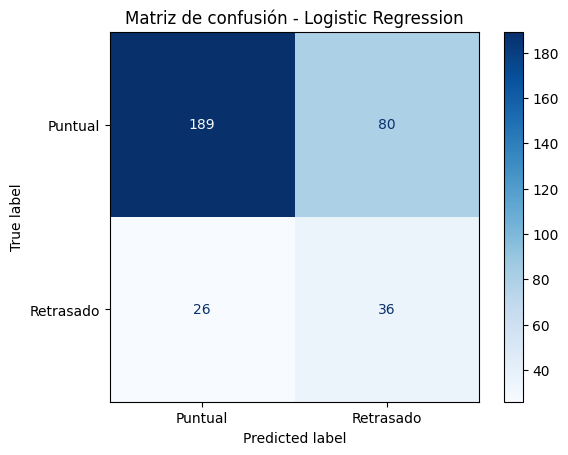

In [ ]:
# Matrices de confusión. Nos permite ver cómo acertamos o fallamos con el modelo.
# confusion_matrix calcula la matriz
# ConfusionMatrixDisplay la dibuja de forma visual

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculamos la matriz de confusión comparando:
# y_test -> valores reales
# y_pred -> predicciones del modelo

cm = confusion_matrix(y_test, y_pred)

# Creamos el objeto de visualización
# Las etiquetas indican:
# Puntual = 0
# Retrasado = 1

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Puntual", "Retrasado"]
)

disp.plot(cmap="Blues")
plt.title("Matriz de confusión - Logistic Regression")
plt.show()

### Paso 9: Matriz de Confusión para Random Forest, Ajuste de Umbral y Modelo Tuned

Esta celda es una continuación del análisis de evaluación y exploración de mejoras:

1.  **Matriz de Confusión (Random Forest)**: Se repite el proceso de la celda anterior para el modelo `RandomForestClassifier` (`rf_model`). Se calcula y visualiza su matriz de confusión para comparar su rendimiento con el de la Regresión Logística.
2.  **Ajuste de Umbral**: Se explora cómo cambiar el umbral de probabilidad para clasificar un vuelo como "Retrasado" puede afectar las métricas del modelo (Regresión Logística). Al aumentar el `threshold` a 0.65, se busca aumentar la precisión a expensas del recall, lo cual es útil en escenarios donde el costo de un falso positivo es alto. Se imprime un nuevo `classification_report` y una `ConfusionMatrixDisplay` con este umbral ajustado.
3.  **Random Forest Ajustado (`rf_model_tuned`)**: Se crea una nueva versión del `RandomForestClassifier` (`rf_model_tuned`) con hiperparámetros ajustados (más `n_estimators` y `min_samples_leaf` para mejorar la generalización). Este modelo se entrena con los datos de entrenamiento.
4.  **Evaluación del Random Forest Ajustado**: Se evalúa el rendimiento de este modelo ajustado, imprimiendo su `classification_report` y `roc_auc_score`, para ver si las modificaciones en los hiperparámetros han logrado una mejora.
5.  **Matriz de Confusión (Random Forest Ajustado)**: Finalmente, se visualiza la matriz de confusión para el `rf_model_tuned`, ofreciendo una vista completa de su comportamiento y permitiendo una comparación final con los modelos anteriores.

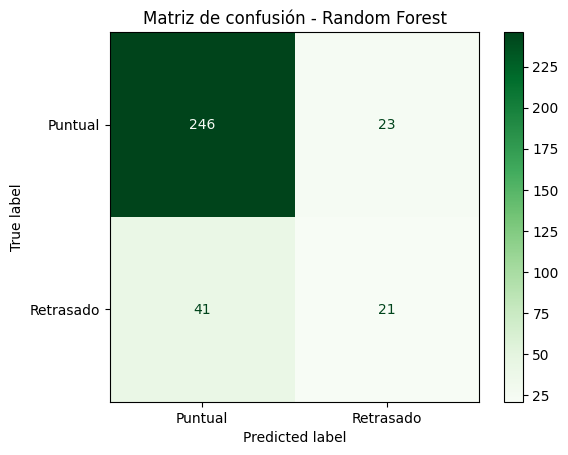

Resultados con umbral = 0.65
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       269
           1       0.33      0.21      0.26        62

    accuracy                           0.77       331
   macro avg       0.58      0.56      0.56       331
weighted avg       0.74      0.77      0.75       331



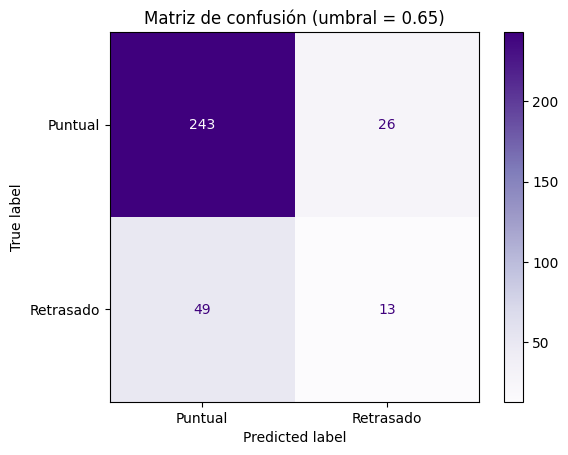

Random Forest ajustado
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       269
           1       0.45      0.37      0.41        62

    accuracy                           0.80       331
   macro avg       0.66      0.63      0.64       331
weighted avg       0.78      0.80      0.79       331

ROC AUC: 0.7272454730783068


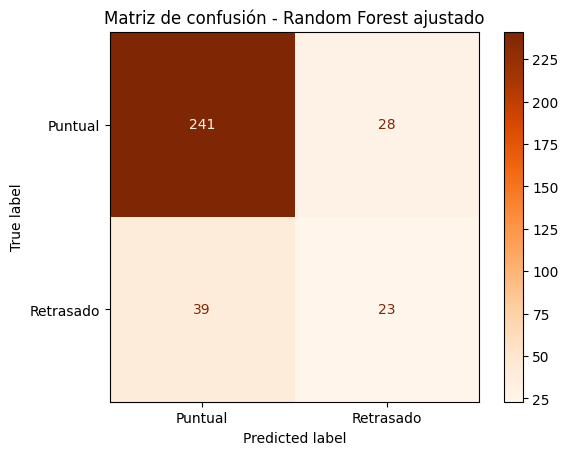

In [ ]:
# Repetimos el mismo análisis que antes
# pero usando el modelo Random Forest

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predicciones del Random Forest
y_pred_rf = rf_model.predict(X_test)

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Creamos el objeto de visualización
# Puntual = 0
# Retrasado = 1

disp_rf = ConfusionMatrixDisplay(
    confusion_matrix=cm_rf,
    display_labels=["Puntual", "Retrasado"]
)

disp_rf.plot(cmap="Greens")
plt.title("Matriz de confusión - Random Forest")
plt.show()

# Ajuste de umbral para aumentar precision

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Probabilidades de retraso
y_proba = model.predict_proba(X_test)[:, 1]

# Umbral más estricto
threshold = 0.65
y_pred_precise = (y_proba >= threshold).astype(int)

# Métricas
print(f"Resultados con umbral = {threshold}")
print(classification_report(y_test, y_pred_precise))

# Matriz de confusión
cm_thresh = confusion_matrix(y_test, y_pred_precise)

disp_thresh = ConfusionMatrixDisplay(
    confusion_matrix=cm_thresh,
    display_labels=["Puntual", "Retrasado"]
)

disp_thresh.plot(cmap="Purples")
plt.title(f"Matriz de confusión (umbral = {threshold})")
plt.show()

# Creamos una versión mejorada del Random Forest
# Ajustando algunos hiperparámetros para mejorar la generalización

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Definimos un nuevo pipeline
# Usamos el mismo preprocesador para asegurar consistencia

rf_model_tuned = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        min_samples_leaf=5,
        random_state=42,
        class_weight="balanced"
    ))
])

# Entrenamos el Random Forest ajustado
# El pipeline aplica automáticamente el preprocesado
# y luego entrena el modelo con los nuevos hiperparámetros

rf_model_tuned.fit(X_train, y_train)

# Calculamos las métricas del modelo una vez entrenado
# Usamos el mismo conjunto de test para comparar con los modelos anteriores

from sklearn.metrics import classification_report, roc_auc_score

# Predicción final del modelo ajustado (0 = puntual, 1 = retrasado)

y_pred_rf_tuned = rf_model_tuned.predict(X_test)

# Probabilidad de retraso para cada vuelo
# Nos quedamos solo con la clase 1 (retrasado)

y_proba_rf_tuned = rf_model_tuned.predict_proba(X_test)[:, 1]

# precision, recall, f1-score y soporte

print("Random Forest ajustado")
print(classification_report(y_test, y_pred_rf_tuned))

# Calculamos el ROC AUC
# Mide la capacidad del modelo para ordenar vuelos
# según su probabilidad de retraso

print("ROC AUC:", roc_auc_score(y_test, y_proba_rf_tuned))

# Visualizamos los aciertos y errores del modelo final
# para entender su comportamiento real en producción

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculamos la matriz de confusión usando:
# y_test -> valores reales
# y_pred_rf_tuned -> predicciones del modelo ajustado

cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)

# Creamos el objeto de visualización
# Puntual = 0
# Retrasado = 1

disp_rf_tuned = ConfusionMatrixDisplay(
    confusion_matrix=cm_rf_tuned,
    display_labels=["Puntual", "Retrasado"]
)

disp_rf_tuned.plot(cmap="Oranges")
plt.title("Matriz de confusión - Random Forest ajustado")
plt.show()


### Paso 10: Conclusiones Finales y Próximos Pasos

Esta celda resume el trabajo realizado en el notebook y ofrece un análisis final de los resultados y las perspectivas futuras:

1.  **Objetivo del Notebook**: Reitera la meta principal de predecir retrasos de vuelos.
2.  **Modelos Probados**: Menciona los tres modelos evaluados: Regresión Logística, Random Forest, y Random Forest ajustado.
3.  **Resultados**: Destaca que el Random Forest ajustado ofrece el mejor equilibrio en el rendimiento.
4.  **Elección del Modelo**: Recomienda el Random Forest ajustado como el modelo para el MVP (Producto Mínimo Viable).
5.  **Uso en Producción**: Explica brevemente cómo se integraría el modelo en un backend (cargando el archivo `.pkl`).
6.  **Limitaciones**: Enumera las restricciones actuales del modelo, como el uso de valores climáticos por defecto o la dependencia del dataset histórico.
7.  **Posibles Mejoras**: Sugiere acciones futuras para mejorar el modelo, como integrar datos climáticos reales, ajustar umbrales de negocio o probar otros modelos. Esta sección es crucial para el crecimiento continuo del proyecto.

In [ ]:
# CONCLUSIONES FINALES


# 1. OBJETIVO DEL NOTEBOOK
# Este notebook tiene como objetivo entrenar y evaluar modelos
# que predicen si un vuelo llegará retrasado o no
# usando información disponible antes del despegue.
#
# 2. MODELOS PROBADOS
# - Regresión Logística: modelo base, simple e interpretable.
# - Random Forest: modelo más complejo, capaz de capturar relaciones no lineales.
# - Random Forest ajustado: versión mejorada con hiperparámetros afinados.
#
# 3. RESULTADOS
# - La regresión logística funciona bien como baseline
#   y es fácil de explicar.
# - El Random Forest mejora la detección de retrasos,
#   especialmente tras el ajuste de hiperparámetros.
# - El modelo ajustado ofrece el mejor equilibrio
#   entre recall, precision y estabilidad.
#
# 4. ELECCIÓN DEL MODELO
# El Random Forest ajustado es el modelo recomendado
# para usar en producción en este MVP,
# ya que detecta mejor los vuelos con riesgo de retraso.
#
# 5. USO EN PRODUCCIÓN
# - El modelo entrenado se guarda en un archivo .pkl.
# - El backend solo debe cargar el modelo y llamar a la función de predicción.
# - No se reentrena el modelo en producción.
#
# 6. LIMITACIONES
# - Algunas variables (clima) se usan con valores por defecto (MVP).
# - El modelo depende de la calidad del dataset histórico.
# - No se ha optimizado el umbral según necesidades de negocio.
#
# 7. POSIBLES MEJORAS
# - Añadir clima real por aeropuerto y fecha.
# - Ajustar el umbral según coste de errores.
# - Probar modelos adicionales o calibrar probabilidades.
# - Automatizar reentrenamiento periódico.
#
# Este notebook sirve como base técnica clara y reproducible
# para el MVP de predicción de retrasos.


#A la espera de mejorar el modelo con una mejor API externa y aplicar algunas herramientas que mejoren el desempeño del modelo.